# Model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
np.set_printoptions(suppress=True)

In [3]:
import tensorflow as tf

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except Exception as e:
    print(e)
tf.config.get_visible_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Dataset

In [5]:
train = pd.read_pickle('dataset/train.pkl')
test = pd.read_pickle('dataset/test.pkl')

In [6]:
train_X = train.drop('target', axis=1).to_numpy()
test_X = test.drop('target', axis=1).to_numpy()

In [7]:
train_y = train['target'].to_numpy()
test_y = test['target'].to_numpy()

In [8]:
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

In [9]:
train_X = np.expand_dims(train_X, axis=-1)
test_X = np.expand_dims(test_X, axis=-1)

In [10]:
train_y[train_y == 1] = 0
test_y[test_y == 1] = 0
train_y[train_y == -1] = 1
test_y[test_y == -1] = 1
train_y = train_y.reshape(-1, 1)
test_y = test_y.reshape(-1, 1)

## Modeling

### CNN

- Deep SHAP Approximation
- Spatial Information을 학습할 수 있기 때문에 CNN이 Time Series에 많이 적용됨

In [11]:
batch_size = 64
epochs = 250

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=20,
        min_lr=0.0001,
    ),
]

In [ ]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

history = cnn.fit(
    train_X,
    train_y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [213]:
cnn.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 500, 64)           256       
                                                                 
 batch_normalization_69 (Bat  (None, 500, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_63 (ReLU)             (None, 500, 64)           0         
                                                                 
 conv1d_73 (Conv1D)          (None, 500, 64)           12352     
                                                                 
 batch_normalization_70 (Bat  (None, 500, 64)          256       
 chNormalization)                                                
                                                                 
 re_lu_64 (ReLU)             (None, 500, 64)         

**Accuracy**

In [178]:
scores = cnn.evaluate(test_X, test_y, batch_size=batch_size, verbose=0)
print(f'Accuracy: {scores[1]}')

Accuracy: 0.9659090638160706


**F1 Score and Confusion Matrix**

In [179]:
pred = cnn.predict(test_X)

42/42 [==============================] - 0s 3ms/step


- Sparse Categorical

In [180]:
pred_label = []
for i in pred:
    pred_label.append(np.argmax(i))

In [183]:
f1 = f1_score(test_y, pred_label)
cm = confusion_matrix(test_y, pred_label)
print(f1)
print(cm)

0.9674149167270094
[[607  32]
 [ 13 668]]


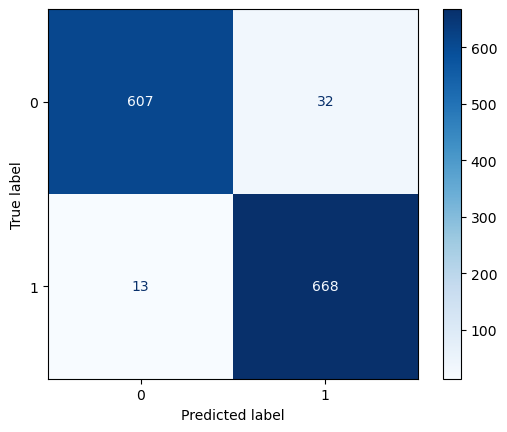

In [212]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_plot.plot(cmap='Blues');

---

### Random Forest

- Tree SHAP Approximation
- CNN보다 훨씬 성능이 떨어짐

In [19]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

In [12]:
model = RandomForestClassifier()
model.fit(train_X, train_y)

RandomForestClassifier()

In [13]:
pred = model.predict(test_X)

In [15]:
f1 = f1_score(test_y, pred)
cm = confusion_matrix(test_y, pred)
print(f1)

0.7610748002904865


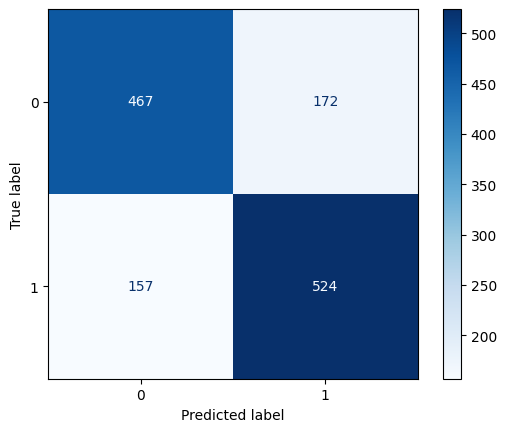

In [16]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_plot.plot(cmap='Blues');

In [20]:
dump(model, 'rf.joblib')

['rf.joblib']